In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [2]:
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report


In [3]:
df = pd.read_csv('cleaned_beer.csv')

In [4]:
import pandas as pd
from textblob import TextBlob

def apply_textblob_sentiment(df):
    """
    Applies TextBlob sentiment analysis to the processed review text in the DataFrame.

    Parameters:
    df (pd.DataFrame or pl.DataFrame): DataFrame containing a column named 'processed_review_text'.

    Returns:
    pd.DataFrame: DataFrame with added 'textblob_polarity' and 'sentiment' columns.
    """
    # Convert to pandas if the DataFrame is not already in pandas format
    if not isinstance(df, pd.DataFrame):
        df = df.to_pandas()
    
    # Apply the TextBlob sentiment analysis
    df['textblob_polarity'] = df['processed_review_text'].apply(lambda text: TextBlob(text).sentiment.polarity)
    
    # Define positive and negative sentiment based on polarity
    df['sentiment'] = df['textblob_polarity'].apply(lambda x: 'positive' if x > 0 else 'negative')
    
    return df

In [5]:
df = apply_textblob_sentiment(df)

### Sentiment Analysis with TextBlob and Polars

In this section, sentiment analysis was used on beer reviews to classify them as positive or negative based on their textual content. We utilized the `TextBlob` library, which is a simple but accurate tool for processing textual data. The key steps in this process are as follows:

1. **Sentiment Analysis with TextBlob**: TextBlob was applied to each review text to calculate the sentiment polarity. The polarity score, ranging from -1 (negative) to +1 (positive), indicates the sentiment of the review. A positive score suggests a positive sentiment, while a negative score indicates a negative sentiment.

2. **Sentiment Classification**: Based on the polarity score,each review was classified as either 'positive' or 'negative'. This classification was added as a new column in the DataFrame named `sentiment`.

This analysis is for understanding customer preferences in the beer market, enabling us to extract valuable insights from the sentiment expressed in reviews. By categorizing reviews into positive and negative sentiments, we can further investigate patterns and correlations that may influence customer satisfaction and market trends.

In [6]:
df.columns

Index(['Unnamed: 0', 'beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name',
       'beer_style', 'review_appearance', 'review_palette', 'review_overall',
       'review_taste', 'review_profileName', 'review_aroma', 'review_text',
       'review_time', 'cleaned_review_text', 'processed_review_text',
       'textblob_polarity', 'sentiment'],
      dtype='object')

In [7]:
X = df['processed_review_text']  # Feature: the review text
y = df['sentiment']

In [8]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_review_text'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Convert sentiments to a binary format if needed
y_train_binary = np.where(y_train == 'positive', 1, 0)

# Calculate class weights
classes = np.unique(y_train_binary)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_binary)
class_weight_dict = dict(zip(classes, class_weights))

### Handling Imbalanced Classes with `compute_class_weight`

Due to more positive than negative review, I found a way to make the balance for the model out with: 

1. **Binary Conversion of Sentiments**: The sentiment labels in the training data (`y_train`) were initially categorical ('positive' and 'negative'). We converted these into a binary format, where 'positive' was mapped to `1` and 'negative' to `0`. This binary conversion facilitates the calculation of class weights and the training of binary classification models.

2. **Class Weight Calculation**: Using the `compute_class_weight` function from `sklearn.utils.class_weight`, we calculated the weights for each class. This function computes weights inversely proportional to class frequencies, ensuring that the minority class receives a higher weight, thereby reducing the bias towards the majority class during model training.

3. **Class Weight Dictionary**: The calculated class weights were stored in a dictionary (`class_weight_dict`), mapping each class label (`0` or `1`) to its corresponding weight. This dictionary can be passed as an argument to the model's training process to balance the class distribution and improve the model's ability to generalize across all classes.
 Since the reviews are skewed positive I found an answer by applying class weights, which enhance the model's performance in predicting minority class instances, leading to more robust and accurate sentiment classification.


### Regression is used first for its simplicity and effectiveness in binary classification tasks.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_test_binary = np.where(y_test == 'positive', 1, 0)

# Define class weight dictionary or use 'balanced'
# Example:
class_weight_dict = {0: 1, 1: 1}  # Adjust weights based on class distribution if necessary

# Create a pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=3, max_df=0.7)),
    ('clf', LogisticRegression(solver='saga', max_iter=100, n_jobs=-1, class_weight=class_weight_dict))
])

# Train the model using binary labels and class weights
pipeline.fit(X_train, y_train_binary)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
report = classification_report(y_test_binary, y_pred)
print("Classification Report:")
print(report)

#  Regression is often chosen for its simplicity and effectiveness in binary classification tasks.Generate confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9773384763741563
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      6385
           1       0.98      1.00      0.99     99389

    accuracy                           0.98    105774
   macro avg       0.96      0.83      0.88    105774
weighted avg       0.98      0.98      0.98    105774

Confusion Matrix:
[[ 4252  2133]
 [  264 99125]]


In [ ]:
#### Accurate but not a accurate as the SVM model

In [24]:
!pip install imbalanced-learn


#### SMOTE for a more balanced sampling: Used for oversampling the minority class in an imbalanced dataset to create a balanced class distribution.

C:\Users\tsher\anaconda3\Lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Random Forest Accuracy: 0.8898595117892866
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.49      0.35      6385
           1       0.97      0.92      0.94     99389

    accuracy                           0.89    105774
   macro avg       0.62      0.70      0.64    105774
weighted avg       0.92      0.89      0.90    105774



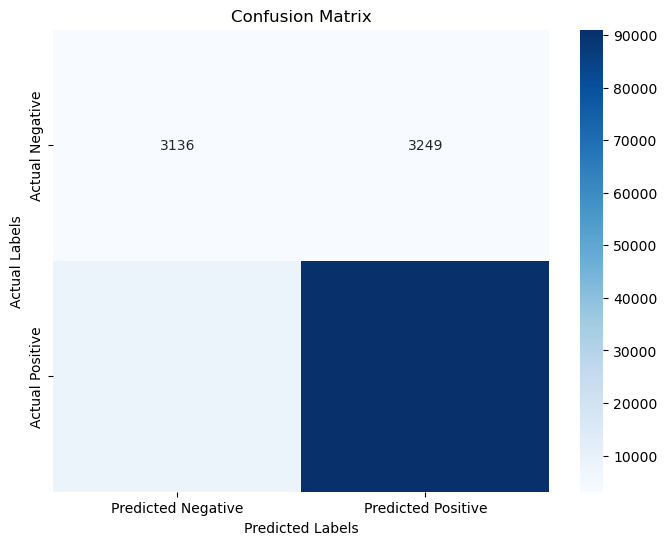

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_test to binary format for evaluation
y_test_binary = np.where(y_test == 'positive', 1, 0)

# Step 1: Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Step 2: Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train_binary)

# Step 3: Train the Random Forest model on the resampled data
rf = RandomForestClassifier(n_estimators=50, max_depth=10, bootstrap=True, n_jobs=-1, class_weight=class_weight_dict)
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on X_test
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_binary, y_pred_rf)
report_rf = classification_report(y_test_binary, y_pred_rf)

# Print the results
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", report_rf)

# Generate and display the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()


### Negative reviews are not being analyzed so it should not be considered

Ensemble Accuracy: 0.9396921738801596
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.00      0.00      6385
           1       0.94      1.00      0.97     99389

    accuracy                           0.94    105774
   macro avg       0.91      0.50      0.49    105774
weighted avg       0.94      0.94      0.91    105774



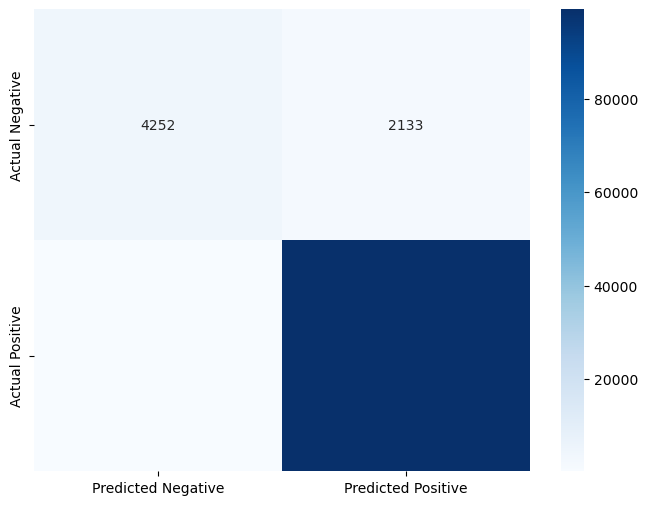

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
# Assuming class_weight_dict and other necessary variables are defined
# Assuming X_train, y_train_binary, X_test, and y_test are already prepared

# Update the parameter name in BaggingClassifier
ensemble_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=5, class_weight=class_weight_dict),
        n_estimators=10,  # Number of trees in the bagging ensemble
        max_samples=0.5,  # Each tree uses 50% of data
        max_features=0.5,  # Each tree uses 50% of features
        n_jobs=-1  # Train trees in parallel
    ))
])

# Train the ensemble model
ensemble_pipeline.fit(X_train, y_train_binary)

# Make predictions with the ensemble
y_pred_ensemble = ensemble_pipeline.predict(X_test)

# Convert y_test to binary format for evaluation
y_test_binary = np.where(y_test == 'positive', 1, 0)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test_binary, y_pred_ensemble)
report_ensemble = classification_report(y_test_binary, y_pred_ensemble)
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])



print("Ensemble Accuracy:", accuracy_ensemble)
print("Ensemble Classification Report:\n", report_ensemble)

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer with the same number of max features
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
MAX_LEN = 200  # Same as your MAX_LEN in model
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Build the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=MAX_LEN, dtype='float32'),
    GRU(24, return_sequences=False),  # Reduce GRU units to make it faster
    Dense(64, activation='relu'),
    Dropout(0.2),  # Slightly reduced dropout to make training faster
    Dense(1, activation='sigmoid', dtype='float32')
])

# Compile the model with Nadam optimizer
model.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare the dataset using tf.data for more efficient loading
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train_binary))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(512).prefetch(tf.data.experimental.AUTOTUNE)

# Fit the model
model.fit(train_dataset, epochs=10, class_weight=class_weight_dict)


Epoch 1/10


C:\Users\tsher\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


827/827 ━━━━━━━━━━━━━━━━━━━━ 256s 306ms/step - accuracy: 0.9464 - loss: 0.1887
Epoch 2/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 260s 314ms/step - accuracy: 0.9834 - loss: 0.0421
Epoch 3/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 274s 332ms/step - accuracy: 0.9884 - loss: 0.0304
Epoch 4/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 263s 317ms/step - accuracy: 0.9916 - loss: 0.0223
Epoch 5/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 262s 317ms/step - accuracy: 0.9939 - loss: 0.0165
Epoch 6/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 274s 332ms/step - accuracy: 0.9955 - loss: 0.0126
Epoch 7/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 281s 340ms/step - accuracy: 0.9967 - loss: 0.0094
Epoch 8/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 275s 332ms/step - accuracy: 0.9971 - loss: 0.0084
Epoch 9/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 275s 333ms/step - accuracy: 0.9976 - loss: 0.0069
Epoch 10/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 286s 346ms/step - accuracy: 0.9979 - loss: 0.0063


In [27]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = model.predict(X_test_pad)
y_pred_binary = (y_pred > 0.5).astype("int32")

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

3306/3306 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step
Accuracy: 0.9810


SVM Accuracy: 0.9848923175827708
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      6385
           1       0.99      0.99      0.99     99389

    accuracy                           0.98    105774
   macro avg       0.95      0.91      0.93    105774
weighted avg       0.98      0.98      0.98    105774



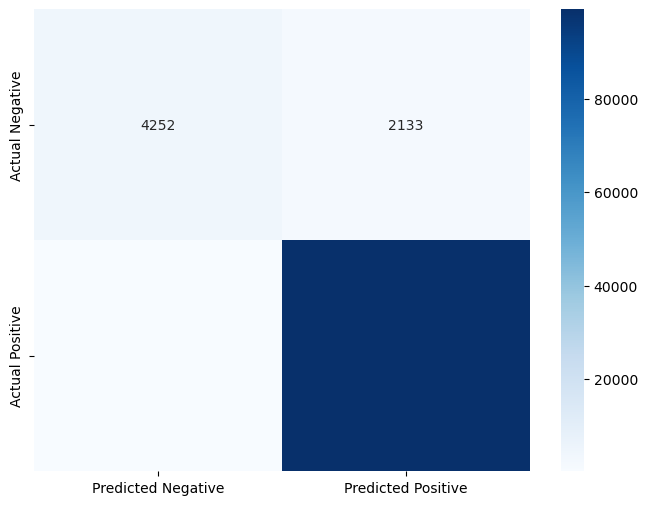

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
# Convert y_test to binary format
y_test_binary = np.where(y_test == 'positive', 1, 0)

# Create a pipeline with TfidfVectorizer and LinearSVC
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7)),
    ('clf', LinearSVC(dual=False, class_weight=class_weight_dict))  # Include class weights
])

# Train the SVM model using binary labels and class weights
svm_pipeline.fit(X_train, y_train_binary)

# Make predictions
y_pred_svm = svm_pipeline.predict(X_test)

# Evaluate the model using binary formatted y_test
accuracy_svm = accuracy_score(y_test_binary, y_pred_svm)
report_svm = classification_report(y_test_binary, y_pred_svm)

# Assuming y_test_binary and y_pred are already defined
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

print("SVM Accuracy:", accuracy_svm)
print("SVM Classification Report:\n", report_svm)

# SVM takes into account negative and positive, The CNN may be little more accurate. But isnt as efficient and it has black box quality to its computation, SVM is the winner due to the fact it is efficient and and easily understood.It also is nearly as accurate as the CNN.

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming the pipeline 'svm_pipeline' is already defined and set up as per your previous code

# Perform cross-validation
scores = cross_val_score(svm_pipeline, X_train, y_train_binary, cv=5, scoring='accuracy')

# Calculate the average and standard deviation of the accuracy
average_accuracy = np.mean(scores)
std_dev_accuracy = np.std(scores)

print("Cross-Validated Accuracy: %0.2f (+/- %0.2f)" % (average_accuracy, std_dev_accuracy * 2))


Cross-Validated Accuracy: 0.98 (+/- 0.00)


In [28]:
import joblib

# Save the trained SVM pipeline to a file
joblib.dump(svm_pipeline, 'svm_pipeline.pkl')

['svm_pipeline.pkl']